In [1]:
import mysql.connector
import pandas as pd

In [2]:
def connect():
  connection = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database = "wp-ecommerce"
  )

  cursor = connection.cursor(dictionary = True)

  return connection, cursor

In [3]:
def get_sales_between_two_dates(start_date, end_date):
  _, cursor = connect()

  sql = '''
    SELECT LEFT(date_created, 10) as date, sum(product_net_revenue) as sales
    FROM wp_wc_order_product_lookup
    WHERE date_created BETWEEN (%s) AND (%s)
    GROUP BY date
    ORDER BY date
  '''

  cursor.execute(sql, (start_date, end_date))

  results = cursor.fetchall()

  entries = []
  for row in results:
    entries.append({
      "date": row["date"],
      "sales": row["sales"]
    })
  
  data = pd.DataFrame(entries)

  return data

In [4]:
from datetime import datetime
from datetime import timedelta

def get_last_sale_date():
  _, cursor = connect()

  sql = '''
    SELECT Left(MAX(date_created), 10) date
    FROM wp_wc_order_product_lookup
  '''

  cursor.execute(sql)

  result = cursor.fetchone()

  last_sale_date = datetime.strptime(result["date"], "%Y-%m-%d")

  return last_sale_date

In [5]:
last_sale_date = get_last_sale_date()
start_date = last_sale_date - timedelta(days = 60)
end_date = last_sale_date + timedelta(days = 1, microseconds =  -1)

start_date, end_date

(datetime.datetime(2023, 2, 11, 0, 0),
 datetime.datetime(2023, 4, 12, 23, 59, 59, 999999))

In [6]:
data = get_sales_between_two_dates(start_date, end_date)

data.head()

,date,sales
0,2023-02-11,322994.621705
1,2023-02-12,368789.834754
2,2023-02-13,331672.604119
3,2023-02-14,396309.916807
4,2023-02-15,350940.804181


In [7]:
data["date"] = pd.to_datetime(data["date"])

data = data.set_index("date")

print("before resample:", len(data.index))

data = data.resample("D").mean()

data["sales"] = data["sales"].fillna(data["sales"].mean())

print("after resample:", len(data.index))

data = data.reset_index()

before resample: 59
after resample: 61


In [ ]:
from autots import AutoTS

forecast_length = 10

model = AutoTS(forecast_length, frequency = "infer")

model = model.fit(data, date_col = "date", value_col = "sales")

In [14]:
prediction = model.predict()

forecast = prediction.forecast

forecast

,0
2023-04-13,21083.567514
2023-04-14,38724.793048
2023-04-15,60420.199911
2023-04-16,66138.064106
2023-04-17,97968.300108
2023-04-18,142556.594691
2023-04-19,151672.184909
2023-04-20,158367.766047
2023-04-21,163423.534059
2023-04-22,167462.227639


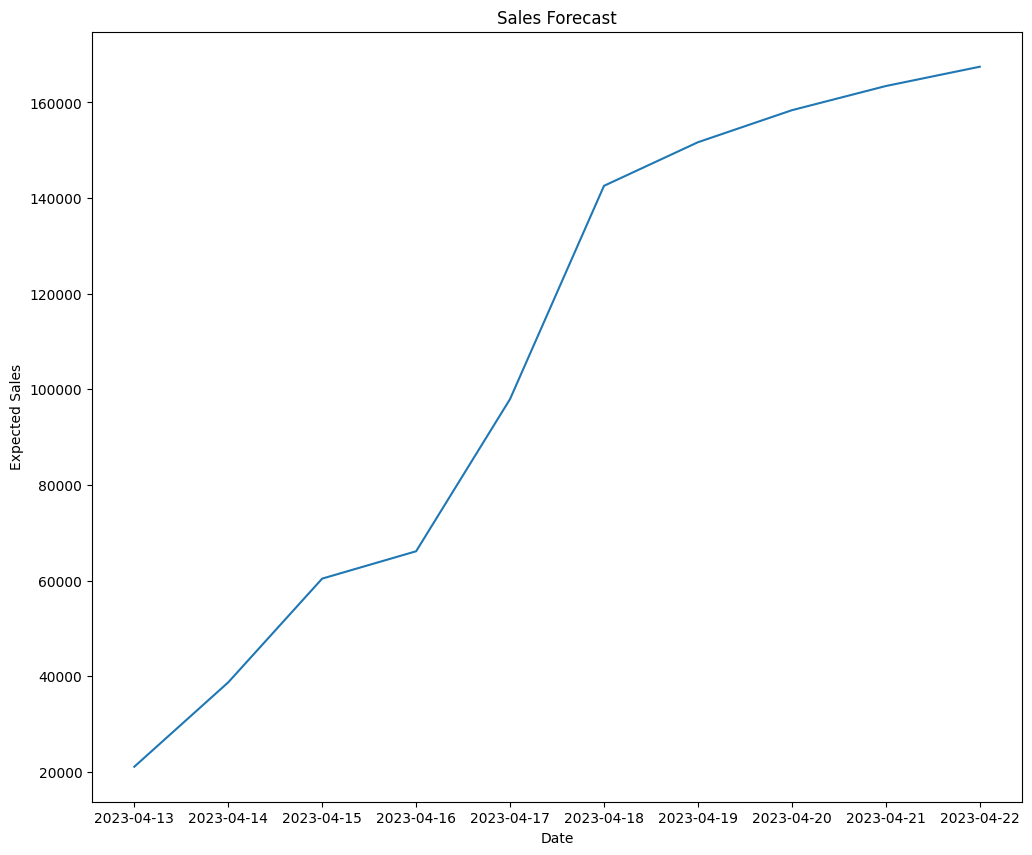

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 10))

plt.title("Sales Forecast")
plt.plot(forecast.index, forecast[0])
plt.xlabel("Date")
plt.ylabel("Expected Sales")
plt.show()

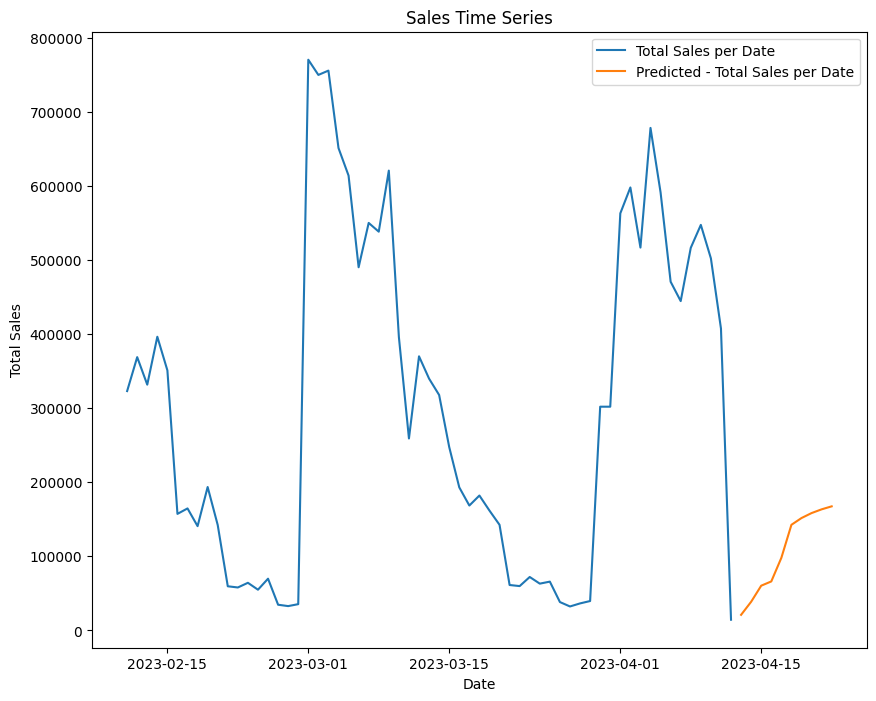

In [27]:
plt.figure(figsize = (10, 8))

data = data.set_index("date")

plt.title("Sales Time Series")
plt.plot(data["sales"], label = "Total Sales per Date")
plt.plot(forecast[0], label = "Predicted - Total Sales per Date")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

data = data.reset_index()

In [ ]:
def export_sales_forecast(forecast):
  connection, cursor = connect()

  sql = "DROP TABLE IF EXISTS wp_wc_sales_forecast"
  
  cursor.execute(sql)

  sql = '''
    CREATE TABLE wp_wc_sales_forecast (
      ID int(11) NOT NULL AUTO_INCREMENT,
      date datetime NOT NULL,
      sales float NOT NULL,
      PRIMARY KEY (ID)
    )
  '''
  
  cursor.execute(sql)
  
  connection.commit()

  for index, row in forecast.iterrows():
    # date = index.strftime("%Y-%m-%d %H:%M:%S")
    date = index.strftime("%Y-%m-%d")
    sales = float(row[0])

    sql = '''
      INSERT INTO wp_wc_sales_forecast VALUES (NULL, %s, %s)
    '''
  
    cursor.execute(sql, (date, sales))
    
    connection.commit()

In [38]:
export_sales_forecast(forecast)

In [36]:
def get_sales_forecast():
  _, cursor = connect()

  sql = "SELECT * FROM wp_wc_sales_forecast"
  
  cursor.execute(sql)

  results = cursor.fetchall()

  entries = []
  for row in results:
    entries.append({
      "date": row["date"],
      "sales": row["sales"],
    })
  
  data = pd.DataFrame(entries)

  return data

In [39]:
forecast_data = get_sales_forecast()

forecast_data

,date,sales
0,2023-04-13,21083.6
1,2023-04-14,38724.8
2,2023-04-15,60420.2
3,2023-04-16,66138.1
4,2023-04-17,97968.3
5,2023-04-18,142557.0
6,2023-04-19,151672.0
7,2023-04-20,158368.0
8,2023-04-21,163424.0
9,2023-04-22,167462.0
